# Project - Natural Language Processing - Spam Filtering

The company ProfessionAI wants to develop a library capable of analyzing received emails.

Specifically, the CEO has requested the identification of SPAM emails on which to perform content analysis.

The CTO has provided you with a dataset and asks you to:

*   Train a classifier to identify SPAM.
*   Identify the main topics among the SPAM emails in the dataset.
*   Calculate the semantic distance between the obtained topics to determine their heterogeneity.
*   Extract the organizations mentioned in the NON-SPAM emails.

# 1 - Project Analysis

The project involves creating an algorithm that can perform spam filtering on received emails.
The goal is to develop a model capable of analyzing the content of emails and identifying those that are SPAM and those that are not.

The project requirements are as follows.

## 1.1 Task 1: Train a classifier to identify SPAM



The Task 1 requires training a classifier to identify spam and non-spam emails.

In this case, it is a binary classifier that will be trained using the dataset provided by the project. The approach for creating the classifier will be as follows:

*   Split the data into training and test sets
*   Select a baseline model
*   Train the baseline model
*   Select additional models
*   Optimize the hyperparameters
*   Train all models
*   Compare the models' metrics
*   Choose the best classifier

The metrics chosen for the comparison between models are:
*   Classification report (Precision, Recall, F1-Score)
*   Confusion Matrix

For the best model choosed a Cross Validation will be executed in order to test its reliability.

## 1.2 Task 2: Identify the main topics among the SPAM emails in the dataset

To identify the Topics of SPAM email a gensim library wil be used.

A BoW (Bag of Words) will be created with all words of SPAM email stored into dataset.

Once the dictionary hass ben created, the Latent Dirichlet Allocation model will be trained to identify the topics into emails.

## 1.3 Task 3: Calculate the semantic distance between the obtained topics to determine their heterogeneity

To calculate the semantic distance between topics it will be done by cosine similarity.

Once the topics are identified, their probability distribution will be stored and used for calculate the cosine similarity between them.

In this waty, the heterogeneity and omogeneity will be discovered between topics.

## 1.4 Task 4: Extract the organizations mentioned in the NON-SPAM emails

To identify all organization contained into NO-SPAM emails the NER (Named Entity Recognition) will be used with gensim.corpora that allows to identify the ORG into corpus text.

Once all ORG are extracted, they will be shown on console.

# 2 - Import Section

In [ ]:
# Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

# Data Pre-Processing (Cleaning)
import string
import spacy
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from imblearn.combine import SMOTEENN

# Word2Vec model
from gensim.models import Word2Vec
import gensim.downloader

# Models
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Topic Modelling
import gensim.corpora as corpora
from sklearn.metrics.pairwise import cosine_similarity

# NER
import spacy.displacy as displacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3 - Constant Declaration

In [ ]:
# Random seed to make reproducible the results
RANDOM_SEED = 42

# Folder that contains the dataset
DATASET_FOLDER = "/content/"

# Name of dataset to be load
DATASET_NAME = "spam_dataset.csv"

# Entire path of dataset
DATASET_PATH = DATASET_FOLDER + DATASET_NAME

# Name of labels
LABELS = ["spam", "ham"]

In [ ]:
# Load English stop words to be deleted from text corpus
ENGLISH_STOPWORDS = stopwords.words('english')

# Load en core web small model to execute POS
NLP = spacy.load('en_core_web_sm')

# Create a set of punctuation to be deleted from text corpus
PUNCTUATION_SET = set(string.punctuation)

# Load the Word2Vec model
GLOVE_MODEL = gensim.downloader.load('glove-wiki-gigaword-300')

# 4 - Classes & Functions Declaration Section

In [ ]:
def plot_class_distribution_barplot(df, column_name):
    """
    Function used to create barplot for frequency distribution of selected variable.

    Parameters:
      - df: pd.DataFrame --> Dataframe from which to retrieve the data
      - column_name: String --> Name of the column to plot

    Return:
      - None
    """
    # Columns to count for classes
    class_counts = df[column_name].value_counts()

    # Define colors for the classes
    colors = ['skyblue', 'salmon']

    # Create the figure
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.index, class_counts.values, color=colors)

    # Set plot titles and labels
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Fix x-ticks
    plt.xticks(class_counts.index, ['Non-Spam', 'Spam'])

    # Add legend to the plot
    plt.legend(bars, ['Non-Spam (0)', 'Spam (1)'])

    # Show the plot
    plt.show()

In [ ]:
def data_cleaner(sentence):
    """
    Function used to clean the text corpus.

    Parameters:
      - sentence: String --> Sentence to be cleaned

    Return:
      - sentence: String --> Cleaned sentence
    """
    # Make lower entire sentence
    sentence = sentence.lower()

    # Remove the punctuation from sentence
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")

    # Remove the numbers from sentence
    sentence = ''.join([i for i in sentence if not i.isdigit()])

    # Lemmatize the sentence
    document = NLP(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in ENGLISH_STOPWORDS)

    # Remove extra spaces
    sentence = re.sub('\d', '', sentence)
    sentence = re.sub(' +', ' ', sentence)

    # Return the cleaned sentence
    return sentence

In [ ]:
def avg_vector(sentence):
    """
    Function used to calculate the avegare vector of sentences.

    Parameters:
      - sentence: String --> Sentence to be cleaned

    Return:
      - vector: np.array --> Average vector of sentence
    """
    # Counter of words to be removed
    to_remove = 0

    # Initialize a 0 vector
    vector = np.zeros(300)

    # For each word contained into sentence if its contained into dictionary
    # add its vector to the average vector
    for word in sentence:
        if word in GLOVE_MODEL.key_to_index.keys():
            vector += GLOVE_MODEL.get_vector(word)
        else:
            to_remove += 1
    if len(sentence)== to_remove:
        return np.zeros(300)

    # Calculate the avegare vector
    return vector/(len(sentence)-to_remove)

In [ ]:
def plot_confusion_matrix(y_true, y_pred,
                          labels=["Negative", "Positive"],
                          show_precision=True,
                          show_recall=True):
    """
    Function used to plot the confusion matrix.

    Parameters:
      - y_true: np.array --> True labels
      - y_pred: np.array --> Predicted labels

    Return:
      - None
    """
    # Create confusion matrix
    cm = confusion_matrix(y_true,
                          y_pred)

    # Create a temporary dataframe with confusion matrix
    df_cm = pd.DataFrame(cm,
                        index = labels,
                        columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
    # Plot the matrix
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [ ]:
def sent_to_words(items):
    """
    Function used to preprocess the text and transform it into single strings removing punctuation.

    Parameters:
      - items: List --> List of sentences to be processed

    Return:
      - Sentences cleaned
    """
    for item in items:
        yield(gensim.utils.simple_preprocess(str(item), deacc=True))

In [ ]:
def remove_stopwords(texts):
    """
    Function used to remove stopwords.

    Parameters:
      - texts: List --> List of sentences to be processed

    Return:
      - Sentences without stopwords
    """
    return [[word for word in words if word not in ENGLISH_STOPWORDS and len(word) >=5] for words in texts]

# 5 - Load Dataset: Emails SPAM and NOT-SPAM

In [ ]:
# Read the csv with pandas
dataset = pd.read_csv(DATASET_PATH, index_col = 0)

It has been used the parameter "*index_col*" with value "*0*" because the dataset contains an **unnamed column** with **ID of row**.
For this reason the unnamed column become the ID column of dataset.

In [ ]:
# Show the first rows of dataset
dataset.head()

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\nthis deal is to ...,0


# 6 - EDA: Exploration Data Analysis

## 6.1 - Dataset General Information

In [ ]:
# Show the dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5171 entries, 605 to 4807
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 161.6+ KB


The column "**text**" represents the core of dataset because contains the entire emails to be analyzed from the model.

The columns "**label**" and "**label_num**" represents the label assigned to the email. In particular, the column "**label**" is the original label that contains "**SPAM**" and "**HAM**", otherwise, the column "**label_num**" is its encoded column where "**0**" represents *NOT-SPAM* and "**1**" represents *SPAM*.

In [ ]:
# Calculate the email text length and store them into dataset
dataset['text_length'] = dataset['text'].apply(lambda x: len(x.split()))

# Show the new dataset
dataset.head()

,label,text,label_num,text_length
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0,67
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,23
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,550
4685,spam,"Subject: photoshop , windows , office . cheap ...",1,48
2030,ham,Subject: re : indian springs\nthis deal is to ...,0,70


In [ ]:
# Calculate the main stastitics of dataset
dataset.describe()

,label_num,text_length
count,5171.000000,5171.000000
mean,0.289886,227.783601
std,0.453753,336.031616
min,0.000000,1.000000
25%,0.000000,51.000000
50%,0.000000,121.000000
75%,1.000000,282.000000
max,1.000000,8862.000000


Summary Statistics:

Label Number (label_num):

*   Count: 5,171 data points
*   Mean: 0.29
*   Standard Deviation: 0.45
*   Minimum: 0
*   25th Percentile (Q1): 0
*   50th Percentile (Median): 0
*   75th Percentile (Q3): 1
*   Maximum: 1

Text Length (text_length):

*   Count: 5,171 data points
*   Mean: 227.78 characters
*   Standard Deviation: 336.03 characters
*   Minimum: 1 character
*   25th Percentile (Q1): 51 characters
*   50th Percentile (Median): 121 characters
*   75th Percentile (Q3): 282 characters
*   Maximum: 8,862 characters


Interpretation:

*   The label_num variable, which could represent a binary classification label, shows that approximately 29% of the samples have a label of 1, while 71% have a label of 0. The standard deviation indicates variability in the labels, though it is relatively low given the binary nature of the data.

*   The text_length variable shows a wide range of text lengths, from very short texts to very long ones. The mean length is about 228 characters, but there's considerable variability (standard deviation of 336 characters), with some texts being much longer than others. The median length (121 characters) indicates that half of the texts are shorter than this value, and the 75th percentile (282 characters) shows that 75% of the texts are shorter than this length. The maximum length of 8,862 characters suggests the presence of a few very long texts in the dataset.

## 6.2 - Features Analysis: Emails

In [ ]:
# Number of emails to print
number_emails = 10

# For each labels print 10 random comments
for label in LABELS:
    print(f"Label: {label}")
    emails = dataset[dataset["label"] == label].sample(n=number_emails, random_state=RANDOM_SEED)['text']
    for i, email in enumerate(emails, 1):
        print(f"{i}. {email}\n")
    print("\n" + "-"*50 + "\n")

Label: spam
1. Subject: liffe is great
hello ,
vlsit our medsbymail shop and save over 80 %
vl
raam
enle
racl
is ,
and
ag
bi
vlt
al
manyother .
you will be pieasantly surprised with our prlces !
have a nice day .

2. Subject: how cuold you do this to a firned ?
save up to 70 % on all kind of drugs
quick ordering amd delivery
fast and free shipping - we have them all
order now - overnight shipping available nowhere else -
we are the only one offering overnight deliver for - - xanax - - + valium - -
click here to order


3. Subject: decadent
soto , \
_ 95 % 0 ff for
all - vi - a - g - ra , c - ia - - l - is , - - l - evitra - - .
credible , devil knows what , desperado , was at stake , tart , after him came , gain , in a brief .


4. Subject: sugper viagrga is fabuklous
only real super viagdra called ciadlis is effective !
annual sale : only $ 3 per dose
check out our website with disscounts and
get your fdree bonus pillls
remove here :
http : / / herbalfactory . net / sv / chair . php



Printing 10 random emails from dataset for each label (*SPAM and NOT SPAM*) there are a lot of **punctuation**, **spaces** and **special chars** to be deleted from text.

## 6.3 - Dataset Balance Analysis

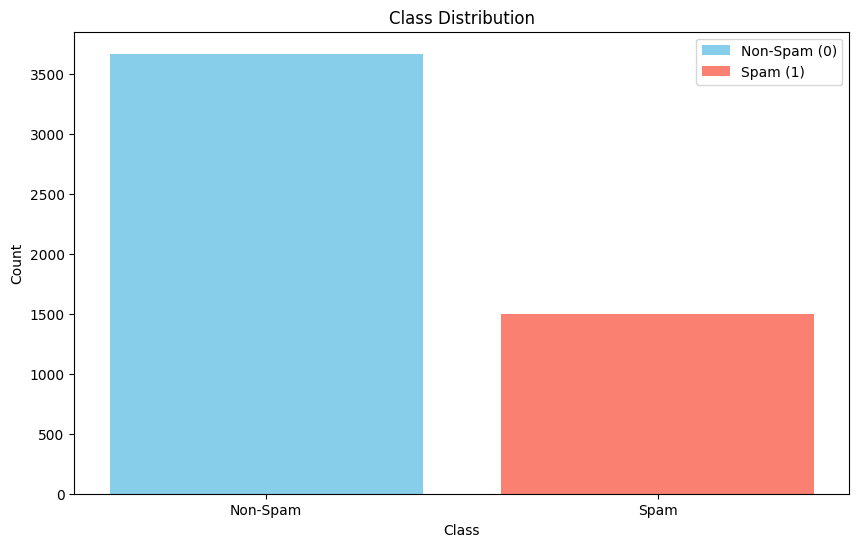

In [ ]:
# Plot the classes distribution
plot_class_distribution_barplot(dataset, "label_num")

In [ ]:
# Count the number of samples for each label
dataset['label_num'].value_counts()

,count
label_num,
0,3672
1,1499


As shown by histogram the dataset is completely unbalanced.

There are **few SPAM** (1499) samples respect to the NON-SPAM (3672).
**For this reason an approach to balance the dataset is needed.**

The dataset at the currently status **is not good for a AI model training**.

This could generate a bad metrics for minority labels and hard recognization for them.

It needs to be more balanced.

# 7 - Data Pre-Processing

## 7.1 - Data Cleaning: lower casing, remove punctuation, lemmatization and remove stop words

Apply data cleaner function in order to remove from text all things useless for model training.

In [ ]:
# Apply to the corpus text the cleaning
dataset['cleaned_text'] = dataset['text'].apply(data_cleaner)

In [ ]:
# Show the dataset with cleaned text
dataset.head()

,label,text,label_num,text_length,cleaned_text
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0,67,subject enron methanol meter follow note I giv...
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,23,subject hpl nom january see attached file hpln...
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,550,subject neon retreat ho ho ho around wonderful...
4685,spam,"Subject: photoshop , windows , office . cheap ...",1,48,subject photoshop window office cheap main tre...
2030,ham,Subject: re : indian springs\nthis deal is to ...,0,70,subject indian spring deal book teco pvr reven...


As shown into dataset, into column "**cleaned_text**", *no more special chars, stop words and spaces appear*.

## 7.2 - Define Features and Labels

Define **features** and **target** variables from dataset.

In [ ]:
# Select Features and Labels from dataframe
X = dataset['text'].values
y = dataset['label_num'].values

## 7.3 - Word2Vec: Create embeddings

In [ ]:
# Initialize the list of embeddings
embeddings = []

# For each sentence compute the average vector
for sentence in X:
    embeddings.append(avg_vector(sentence))

In [ ]:
# Check the embedding transformation
embeddings[0]

array([-0.22023059,  0.0198757 , -0.24308308, -0.05358775, -0.56041509,
        0.04811445, -0.07199555,  0.23058129, -0.30409662, -1.11182381,
        0.08711834,  0.0939526 , -0.34344801,  0.13422405, -0.03894611,
       -0.15240233, -0.2519495 ,  0.32439394,  0.18193132, -0.03037981,
       -0.17583131, -0.13016962, -0.05703101,  0.06475753, -0.00931296,
        0.15450432,  0.16376377,  0.15288405,  0.3292124 , -0.39338226,
       -0.09249119,  0.38598457, -0.23142695, -0.06427967, -0.68323859,
        0.0274547 ,  0.31023655, -0.39983976, -0.24817988,  0.19023167,
       -0.11435837,  0.03957632, -0.502581  ,  0.57777811, -0.29601038,
       -0.25849312,  0.2390996 , -0.05269312,  0.0588249 ,  0.06019295,
        0.05782403,  0.18243776, -0.08584659,  0.09248253, -0.06654225,
        0.31023482,  0.12081361, -0.04443069,  0.05286129, -0.4231608 ,
        0.3935678 ,  0.19943169,  0.08771598,  0.13894892, -0.07893682,
       -0.14075611, -0.16815665,  0.11146514,  0.26465304, -0.20

## 7.4 - Balance the data with SMOTEEN technique

To balance the data for the training, it has been chosen the SMOTEEN technique that apply an hybrid balancing.

In [ ]:
# Initialize the SMOTE
smote_enn = SMOTEENN(random_state=RANDOM_SEED)

# Execute the resample and then balance the data
x_resampled, y_resampled = smote_enn.fit_resample(embeddings, y)

In [ ]:
# Counts the sample for each label
np.unique(y_resampled, return_counts=True)

(array([0, 1]), array([2851, 3390]))

In this way, the SMOTE **algorithm has been restored the balance of data** and then they are **ready for training** a model.

## 7.5 - Define Train and Test data

In [ ]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(x_resampled,
                                                    y_resampled,
                                                    test_size=.2,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y_resampled)

In [ ]:
# Make numpy array the train and test data
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Check the train and test data shape
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (4992, 300)
X_test shape: (1249, 300)
y_train shape: (4992,)
y_test shape: (1249,)


# 8 - Task 1: Model Exploration

## 8.1 - Logistic Regression Model (baseline)

In [ ]:
# Initialize Logistic Regression model
lr = LogisticRegression()

# Fit Logistic Regression model
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Print the classification report
print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       544
           1       0.97      0.93      0.95       705

    accuracy                           0.94      1249
   macro avg       0.94      0.94      0.94      1249
weighted avg       0.94      0.94      0.94      1249



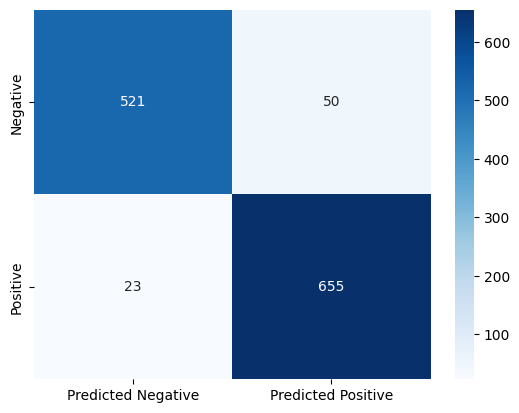

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, lr.predict(X_test))

## 8.2 - Naive Bayes Model

### 8.2.1 - Bernoulli Naive Bayes

In [ ]:
# Initialize Bernoulli model
bnb = BernoulliNB()

# Fit the Bernoulli model
bnb.fit(X_train, y_train)

BernoulliNB()

In [ ]:
# Print the classification report
print(classification_report(bnb.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77       431
           1       0.93      0.77      0.84       818

    accuracy                           0.81      1249
   macro avg       0.80      0.83      0.81      1249
weighted avg       0.84      0.81      0.82      1249



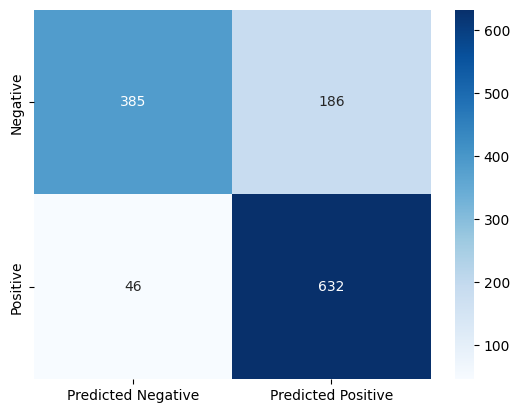

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, bnb.predict(X_test))

### 8.2.2 - Complement Naive Bayes

The Complement Naive Bayes model cannto be used because **it doesn't accept the negative values into training**.

### 8.2.3 - Multinomial Naive Bayes

The Multinomial Naive Bayes model cannto be used because **it doesn't accept the negative values into training**.

## 8.3 - Support Vector Machine

In [ ]:
# Initialize SVC model
svc = SVC()

# Fit SVC model
svc.fit(X_train, y_train)

SVC()

In [ ]:
# Print the classification report
print(classification_report(svc.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       526
           1       0.96      0.90      0.93       723

    accuracy                           0.92      1249
   macro avg       0.92      0.93      0.92      1249
weighted avg       0.93      0.92      0.92      1249



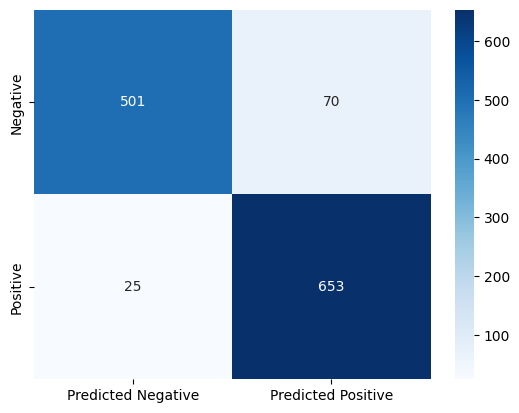

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, svc.predict(X_test))

## 8.4 - Best Model: Conclusion

The three main machine learning models for classification were trained: Logistic Regression, SVC, and Naive Bayes. The approach was to choose a baseline model, Logistic Regression, and train other models to see which one could provide better metrics.

*Without resorting to neural networks and without excessively using resources for hyperparameter* tuning and optimization, Logistic Regression already provided more than **sufficient metrics for classification**, and for this reason, it was chosen as **the best classifier**.

## 8.5 - Cross Validation: More checks on Best Model

In [ ]:
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
print("Accuracy for each fold:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

Accuracy for each fold: [0.93293293 0.92092092 0.92685371 0.92184369 0.91382766]
Mean accuracy: 0.9232757807908107
Standard deviation: 0.006370643265346233


# 9 - Task 2: Identify Main Topics

In [ ]:
# Extract spam words from dataset
spam_words = dataset[dataset['label_num'] == 1]['cleaned_text']

In [ ]:
# Generate for each document a list of words
data_words = list(sent_to_words(spam_words))

In [ ]:
# Remove stop words
data_words = remove_stopwords(data_words)

In [ ]:
# Create Dictionary mapping each single word with unique ID
id2word = corpora.Dictionary(data_words)

In [ ]:
# For each document create a couple of word_id and frequency
corpus = [id2word.doc2bow(text) for text in data_words]

In [ ]:
# Number of topics
num_topics = 10

# Passes
passes = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       passes=passes,
                                       random_state=RANDOM_SEED)

In [ ]:
# Print the topics identified
pprint(lda_model.print_topics())

[(0,
  '0.010*"subject" + 0.004*"price" + 0.004*"download" + 0.004*"review" + '
  '0.003*"source" + 0.003*"story" + 0.003*"january" + 0.003*"instant" + '
  '0.003*"citibank" + 0.003*"microsoft"'),
 (1,
  '0.010*"subject" + 0.009*"email" + 0.005*"rolex" + 0.005*"watch" + '
  '0.003*"music" + 0.003*"online" + 0.002*"artprice" + 0.002*"replica" + '
  '0.002*"million" + 0.002*"address"'),
 (2,
  '0.024*"subject" + 0.008*"account" + 0.007*"please" + 0.006*"offer" + '
  '0.006*"money" + 0.005*"click" + 0.005*"online" + 0.004*"visit" + '
  '0.004*"price" + 0.004*"internet"'),
 (3,
  '0.022*"company" + 0.014*"statement" + 0.012*"stock" + 0.010*"price" + '
  '0.009*"information" + 0.008*"security" + 0.008*"report" + 0.008*"within" + '
  '0.007*"investment" + 0.005*"forward"'),
 (4,
  '0.011*"subject" + 0.006*"number" + 0.005*"company" + 0.005*"claim" + '
  '0.005*"international" + 0.005*"email" + 0.004*"please" + 0.004*"account" + '
  '0.004*"money" + 0.003*"program"'),
 (5,
  '0.016*"subject" 

# 10 - Task 3: Calculate Semantics Distance

In [ ]:
# Store the probability distribution of topics
topics = lda_model.get_topics()

In [ ]:
# Compute the cosine similarities between topics
cosine_similarities = cosine_similarity(topics)

# Print the cosine similarity matrix
print(cosine_similarities)

[[1.0000141  0.49513578 0.5901001  0.34541655 0.52396035 0.41240183
  0.5638042  0.2483152  0.4825925  0.5315172 ]
 [0.49513578 1.0000252  0.607516   0.28197798 0.5339561  0.43527675
  0.50695544 0.20036177 0.45059076 0.56924206]
 [0.5901001  0.607516   1.0000206  0.36806276 0.686963   0.5722138
  0.6571562  0.2070405  0.56764877 0.72800964]
 [0.34541655 0.28197798 0.36806276 1.0000807  0.5094339  0.24022225
  0.31437847 0.11141361 0.6895352  0.3000578 ]
 [0.52396035 0.5339561  0.686963   0.5094339  0.9999713  0.4406933
  0.49329618 0.22186215 0.59744626 0.5415814 ]
 [0.41240183 0.43527675 0.5722138  0.24022225 0.4406933  0.99995923
  0.45279354 0.1633058  0.3462898  0.46364847]
 [0.5638042  0.50695544 0.6571562  0.31437847 0.49329618 0.45279354
  1.0000315  0.27367687 0.48656332 0.6840203 ]
 [0.2483152  0.20036177 0.2070405  0.11141361 0.22186215 0.1633058
  0.27367687 0.99993694 0.1832892  0.19228412]
 [0.4825925  0.45059076 0.56764877 0.6895352  0.59744626 0.3462898
  0.48656332 0.1

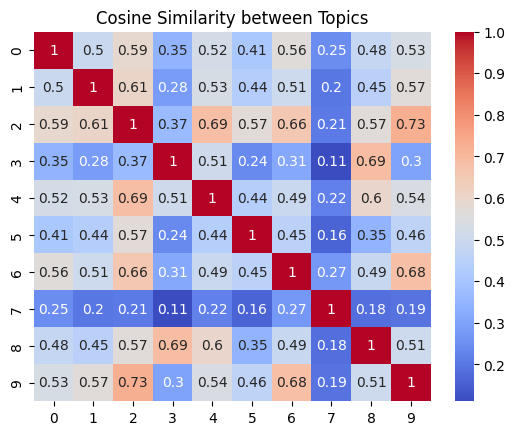

In [ ]:
# Plot the matrix of cosine similarity between topics
sns.heatmap(cosine_similarities,
            annot=True,
            cmap='coolwarm',
            xticklabels=range(len(topics)),
            yticklabels=range(len(topics)))

plt.title('Cosine Similarity between Topics')
plt.show()

As shown by the cosine similarity matrix of topics, it is possible to notice that there are some similar topic such as:

*   Number 2 similar to 6, 4 and 9
*   Number 3 similar to 8
*   Number 6 similar to 9 and 2
*   Number 9 similar to 6 and 2

Checking the explicit topics:

  (2,
  '0.024*"subject" + 0.008*"account" + 0.007*"please" + 0.006*"offer" + '
  '0.006*"money" + 0.005*"click" + 0.005*"online" + 0.004*"visit" + '
  '0.004*"price" + 0.004*"internet"')

  (6,
  '0.013*"subject" + 0.007*"price" + 0.004*"software" + 0.003*"click" + '
  '0.003*"window" + 0.003*"retail" + 0.003*"xanax" + 0.003*"today" + '
  '0.002*"offer" + 0.002*"quick"')

  (4,
  '0.011*"subject" + 0.006*"number" + 0.005*"company" + 0.005*"claim" + '
  '0.005*"international" + 0.005*"email" + 0.004*"please" + 0.004*"account" + '
  '0.004*"money" + 0.003*"program"')

The topics are related between them considering the words "**please**", "**price**" and "**money**".

The rest of topics not analyzed are heterogeneous between them, no strong relationship between thema are present escluding the topics analyzed.

**They seem to be words related to money offers that entice the user to accept and potentially fall victim to scams.**

# 11 - Task 4: Extract Organizations from NO-SPAM

In [ ]:
# Initialize organization list
organizations = []

In [ ]:
# For each email NO-SPAM extract the ORG identified
for doc in dataset[dataset['label_num']==0]['text']:
    spacy_doc = NLP(doc)

    for ent in spacy_doc.ents:
        if ent.label_ == 'ORG':
            organizations.append(ent.text)

In [ ]:
# Remove the duplication with set and store the list of ORG
organizations = list(set(organizations))

In [ ]:
# Show the organization extracted
print(organizations)

['samson lone star limited', 'resources , inc', 'houston pipeline', 'texas 0', 'hplc - im', 'lilly', 'fidelity investments', 'sta', 'pioneer', 'corp tax', 'mondragon', 'joseph p hirl / enron _ development @ enron _', 'ene', 'ena ( ews ) canada origination & trading - calgary', 'dana daigle / corp /', 'cowtrap &', 'cp & l', 'cooper / gco / enron @ enron', 'chris riegler / corp / enron @ enron', 'hplc texas', 'martin', 'srm', 'laura harder / corp / enron @ enron\nsubject', 'gmt company inc', 'philadelphia inquirer', 'pat clynes / corp /', 'mobil beaumont', 'jott @ rsn', 'columbus energy corp', 'ena invoice', 'camille gerard / corp / enron @ enron', 'night - sigmund & freud', 'hetherington - canada', 'fariba', 'zeman / corp / enron @ enron', 'delta air lines , inc .', 'the houston exploration company', '9603', 'brenham', 'coastal o & g', 'brenda herod &', 'cdp', 'jennings ranch\n', 'gulf gas utilities', 'john hodge / corp /', '\x01', 'ewn', 'h & w', 'c & e berclair\n989813', 'kafus enviro

# 12 - Conclusion

The project was undertaken with the goal of developing an effective classifier to distinguish between SPAM and non-SPAM emails, while optimizing resource usage and improving the model's accuracy. The following conclusions summarize the results and potential future directions of the work:

*   **SPAM and Non-SPAM Classification**:
A classifier was trained to differentiate between SPAM and non-SPAM emails. The current model has achieved satisfactory results in classification; however, there are opportunities for further improvement. Hyperparameter optimization could enhance its performance, and exploring advanced Deep Learning techniques, such as neural networks, could lead to significant improvements.

*   **Identification of Main Topics in SPAM Emails**:
Topic modeling was performed to identify the main topics within SPAM emails. This analysis revealed recurring themes characteristic of SPAM communications. However, further exploration could be beneficial for uncovering new topics or subtopics by increasing the number of iterations and fine-tuning the model.

*   **Calculation of Semantic Distance Between Topics**:
To assess the diversity between identified topics, semantic distance was calculated using cosine similarity. This approach provided valuable insights into the similarity between various topics and highlighted their heterogeneity. The distances between topics help in understanding the distribution and variation of themes within SPAM emails.

*   **Extraction of Organizations from Non-SPAM Emails**:
Named Entity Recognition (NER) was used to extract the names of organizations mentioned in non-SPAM emails. This step contributed to identifying business and organizational entities, providing additional insights into the content of non-SPAM emails.

**Future Recommendations**

Optimization and Deep Learning: Consider hyperparameter optimization to improve the classifier and evaluate the implementation of Deep Learning models to explore new classification techniques.
Expansion of Topic Modeling: Increase the number of iterations in topic modeling and experiment with different configurations to discover new topics and refine the model’s convergence.
Advanced Analysis and Visualization: Utilize advanced visualization techniques to represent relationships between topics and extracted organizations, thereby enhancing the interpretation and analysis of results.
In conclusion, the project achieved its main objectives and provided an in-depth analysis of SPAM and non-SPAM emails. The results offer a solid foundation for further improvements and future research in the field of Natural Language Processing.